### <b> Problem Description </b>

Problem : Typical node classification problem. We have a large social network of GitHub developers named musae-github (https://snap.stanford.edu/data/githubsocial.html) 

* Nodes represent developers (platform users) who have starred at least 10 repositories 
* edges are mutual follower relationships between them (note that word mutual indicates undirected relationship).
* The node features are extracted based on the location, repositories starred, employer and e-mail address
* Our task is to predict whether the GitHub user is a web or a machine learning developer

<table>
  <tr>
    <th>Dataset</th>
    <th>Directed</th>
    <th>Node features</th>
    <th>Edge features</th>
    <th>Node labels</th>
    <th>Temporal</th>
    <th>Nodes</th>
    <th>Edges</th>
  </tr>
  <tr>
    <td>Dataset statistics</td>
    <td>No</td>
    <td>Yes</td>
    <td>No</td>
    <td>Yes. Binary-labeled.</td>
    <td>No</td>
    <td>37,700</td>
    <td>289,003</td>
  </tr>
</table>


### <b> Importing Libraries </b>

In [2]:
%reset

In [3]:
%matplotlib inline
import json
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data # used to construct graph data discussed later
# from torch_geometric.transforms import AddTrainValTestMask  #lets write code for this shit
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv
import networkx as nx


## <b> Analysis </b>

File structure : <br>
* musae_git_edges.csv --> says the edge between one node to another 
* musae_git_features.json --> vectors that denote the features of each node
* musae_git_target.csv --> gives info about the whether the user is a ml_dev or not

In [4]:
user_data=pd.read_csv("data/musae_git_target.csv")
print ("Total number of users : ",len(user_data["id"].unique()))
user_data.head(5)

Total number of users :  37700


,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


Total number of users :  37700


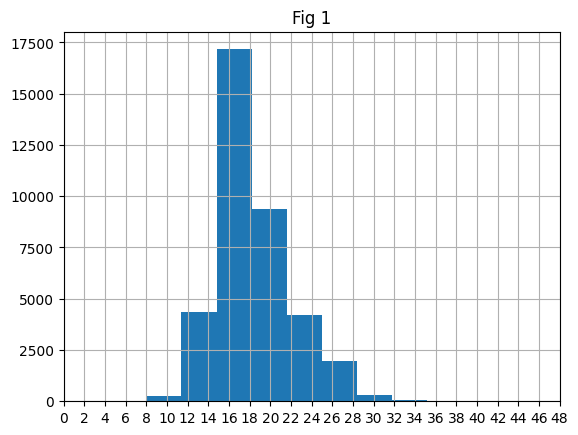

In [5]:
node_features=open("data/musae_git_features.json")
data = json.load(node_features)
print("Total number of users : ",len(data.keys()))
feature_counts=[]
for key,value in data.items():
    feature_counts.append(len(value)) #appending feature vector length to feature_counts vector
pd.DataFrame(feature_counts)
plt.hist(pd.DataFrame(feature_counts)[0],bins=10) #bins are the intervals -> if 5 then the data is divided into 5 parts
plt.xticks([i for i in range(0,50,2)])
plt.grid()
plt.title("Fig 1")
plt.show()

From the histogram it is evident that most of the nodes have the feature vector of size 15 to 18 

In [6]:
edges=pd.read_csv("data/musae_git_edges.csv")
len(edges["id_1"].unique()),len(edges["id_2"].unique())

(30855, 30195)

Try to create the node which has atleast 3 connections

<b> Conclusion of analysis </b>
* Totally there are 37700 users 
* each user has various features some has a feature of len 8 and some has the feature of length 32 also

## <b> Preprocessing </b>

Trying to create a dense vector
* found that a element in a vector representation of a node occurs only at some particular index  say : 3214 is always found in the 2nd index
* lets cut the feature vector to 15 dim --> take all vec which has dim 15 to 20 and do the cut off(slicing)
* and lets find the MODE(each idx)
* idx_mode={1:23,2:124,3:3214,.....15:345}
* based on this we'll give the score to each node means if the node has matched the idx mode by 15/15 then its probabiliy of selection is 1
* we'll select the node only it has more than the score of 0.75

In [7]:
selected_nodes=dict()
for key,value in data.items():
    if len(value)>=15: #node got selected
        selected_nodes[key]=value[:15]

In [8]:
selected_nodes=pd.DataFrame(selected_nodes).transpose()

In [9]:
idx_mode=selected_nodes.mode().iloc[0].to_dict()

In [10]:
idx_mode

{0: 1574,
 1: 3773,
 2: 1793,
 3: 3129,
 4: 3129,
 5: 1852,
 6: 3077,
 7: 1171,
 8: 3763,
 9: 536,
 10: 536,
 11: 536,
 12: 1532,
 13: 2472,
 14: 2472}

In [11]:
prob_all_nodes=[]
for row in selected_nodes.iterrows():
    row=row[1].to_dict()
    selection_prob=0
    for idx,value in row.items():
        if value==idx_mode[idx]:
            selection_prob+=1
    selection_prob=selection_prob/len(row)
    prob_all_nodes.append(selection_prob)

In [12]:
prob_all_nodes=pd.DataFrame(prob_all_nodes,columns=["selection_prob"])

In [13]:
selected_nodes.reset_index(inplace=True)

In [14]:
selected_nodes=pd.concat([selected_nodes,prob_all_nodes],axis=1)

In [15]:
selected_nodes

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,selection_prob
0,0,1574,3773,3571,2672,2478,2534,3129,3077,1171,2045,1539,902,1532,2472,1122,0.266667
1,1,1193,376,73,290,3129,1852,3077,1171,1022,2045,536,2040,1533,1532,2472,0.400000
2,2,1574,3773,925,1728,2815,2963,3077,364,1171,536,1867,2472,1122,2532,664,0.266667
3,3,3964,3773,4003,928,1852,3077,364,1022,3763,2045,3859,3771,234,664,703,0.133333
4,4,1929,3773,1793,3511,1290,3129,3077,364,1171,1022,2045,536,1119,91,1532,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33058,37695,1574,3773,73,1995,3554,1233,1789,345,3129,1852,3077,1171,3763,2045,2046,0.133333
33059,37696,1929,3773,1663,1404,508,819,1852,3077,364,1171,3763,536,81,1532,2472,0.200000
33060,37697,3433,3773,3104,1245,3129,1852,3077,364,1171,3763,2045,2459,368,1532,2472,0.333333
33061,37698,3730,3773,1695,2092,2954,1852,3077,364,1171,1022,3763,536,1968,2205,2472,0.333333


(array([ 8170., 13688.,  8760.,  2290.,   155.]),
 array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 ]),
 <BarContainer object of 5 artists>)

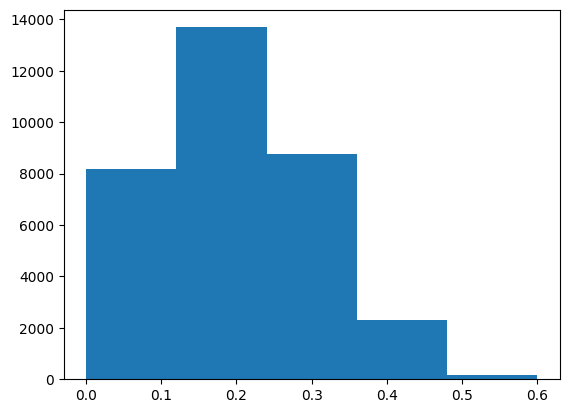

In [200]:
plt.hist(selected_nodes["selection_prob"],bins=5)

if some element goes beyond 25 % percentage match then that node is selected

In [16]:
selected_nodes_filtered = selected_nodes[selected_nodes['selection_prob'] > 0.45]

In [17]:
selected_nodes_filtered

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,selection_prob
78,90,3964,3773,1793,847,3129,1852,3077,364,1171,3763,536,2682,3565,2472,234,0.466667
134,158,1929,1330,1793,2947,3129,1852,3077,364,3763,536,1125,3518,2564,652,2472,0.466667
156,186,3730,3773,3104,1254,3129,1852,3077,1171,1022,3763,2045,536,16,1532,2472,0.466667
169,202,3730,3773,1663,1601,3129,1852,3077,1171,1022,3763,2045,536,3496,3538,2472,0.466667
194,228,2048,3773,1793,2392,3129,1852,3077,1171,1022,3763,2045,536,1507,1532,3771,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32820,37420,3433,746,1793,2947,3129,1852,3077,364,2045,536,3447,1444,1532,2472,1122,0.466667
32917,37535,954,3971,1663,490,3129,1852,3077,364,3763,2045,536,3465,1532,2472,3794,0.466667
32926,37545,3433,3773,3571,2039,3129,1852,3077,1171,3763,2045,536,1927,894,2472,1348,0.533333
32996,37626,3730,3773,1793,2947,3129,1852,364,1171,3763,2045,536,2046,1702,2472,1348,0.533333
